CSV_PATH : C:\Users\JH\data_lab\Project-FXCast\Project-FXCast\2026\data\df_final_2026_with_gdelt_and_news.csv
PRED_PATH: C:\Users\JH\data_lab\Project-FXCast\Project-FXCast\output_paper_protocol_resume\holdout_predictions_partial_LSTM_GRU_CNNLSTM_CNNGRU.csv
[CHECK] Baseline GRU (Macro Only) | lb=20 rows = 216
[CHECK] Best CNN-GRU (Macro+Event+Sent(Both)) | lb=20 rows = 216
split_date (holdout start): 2024-01-23


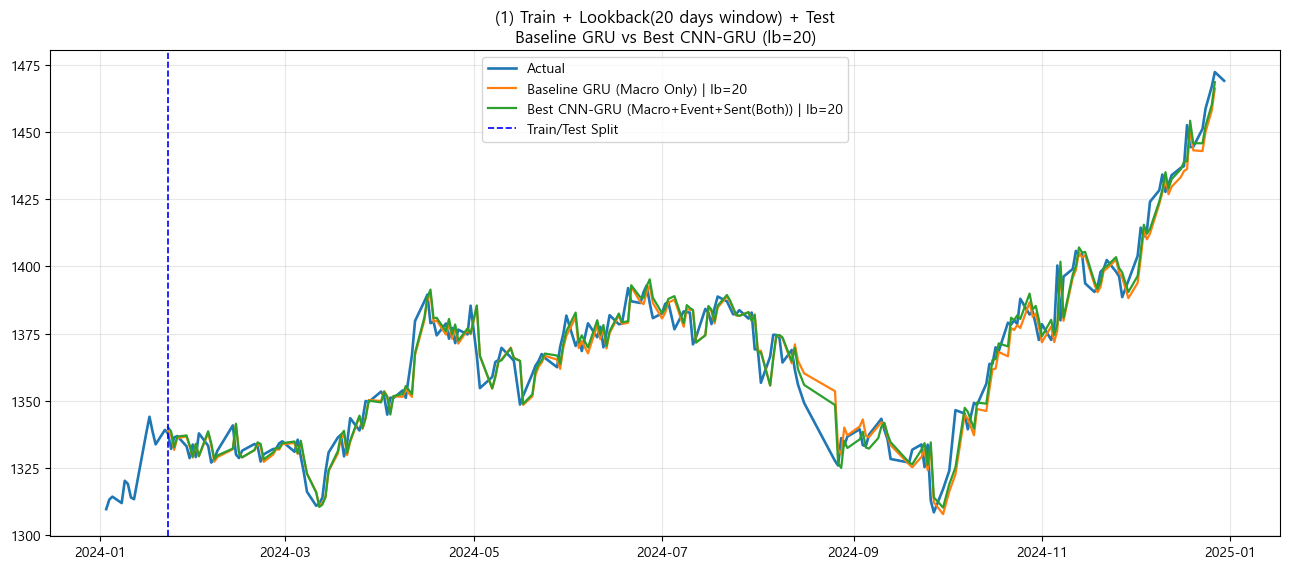

Saved: C:\Users\JH\data_lab\Project-FXCast\Project-FXCast\output_paper_protocol_resume\viz_compare_baselineGRU_vs_bestCNNGRU_lb20\01_train_lb20_window_plus_test.png


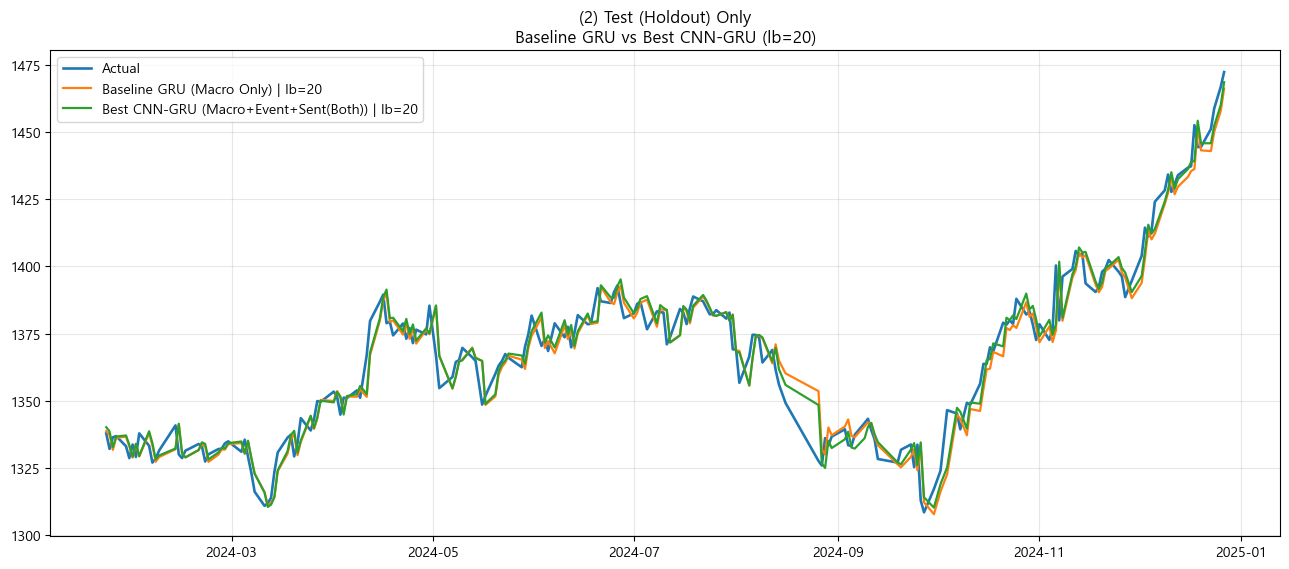

Saved: C:\Users\JH\data_lab\Project-FXCast\Project-FXCast\output_paper_protocol_resume\viz_compare_baselineGRU_vs_bestCNNGRU_lb20\02_test_only.png

 DONE


In [1]:
# ============================================================
# Paper-ready Visualization (2 Figures)
# (1) Train + Lookback(20d window) + Test:
#     Baseline GRU (Macro Only, lb=20) vs Best CNN-GRU (Macro+Event+Sent(Both), lb=20)
# (2) Test(Holdout) Only:
#     Baseline vs Best
# ============================================================

import os, platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# ============================================================
# 0) Project Root
# ============================================================
PROJECT_ROOT = r"C:\Users\JH\data_lab\Project-FXCast\Project-FXCast"

CSV_PATH = os.path.join(PROJECT_ROOT, "2026", "data", "df_final_2026_with_gdelt_and_news.csv")
OUT_DIR  = os.path.join(PROJECT_ROOT, "output_paper_protocol_resume")
PRED_PATH = os.path.join(OUT_DIR, "holdout_predictions_partial_LSTM_GRU_CNNLSTM_CNNGRU.csv")

SAVE_DIR = os.path.join(OUT_DIR, "viz_compare_baselineGRU_vs_bestCNNGRU_lb20")
os.makedirs(SAVE_DIR, exist_ok=True)

# ============================================================
# 1) Korean Font
# ============================================================
def set_korean_font():
    if platform.system() == "Windows":
        font_path = "C:/Windows/Fonts/malgun.ttf"
    elif platform.system() == "Darwin":
        font_path = "/System/Library/Fonts/AppleGothic.ttf"
    else:
        font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

    if os.path.exists(font_path):
        font_name = fm.FontProperties(fname=font_path).get_name()
        plt.rcParams["font.family"] = font_name
    plt.rcParams["axes.unicode_minus"] = False

set_korean_font()

# ============================================================
# 2) Config
# ============================================================
DATE_COL   = "date"
TARGET_COL = "USD_KRW 종가"
LOOKBACK_DAYS = 20
SHIFT = 1

BASELINE = dict(
    case="Macro Only",
    model="GRU",
    lookback=20,
    shift=SHIFT,
    tag="Baseline GRU (Macro Only) | lb=20"
)

BEST = dict(
    case="Macro + Event + Sentiment (Both)",
    model="CNN-GRU",
    lookback=20,
    shift=SHIFT,
    tag="Best CNN-GRU (Macro+Event+Sent(Both)) | lb=20"
)

# ============================================================
# 3) File check
# ============================================================
print("CSV_PATH :", CSV_PATH)
print("PRED_PATH:", PRED_PATH)

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV 파일 없음: {CSV_PATH}")
if not os.path.exists(PRED_PATH):
    raise FileNotFoundError(f"예측 파일 없음: {PRED_PATH}")

# ============================================================
# 4) Load true series (full period)
# ============================================================
df_raw = pd.read_csv(CSV_PATH, encoding="utf-8-sig").replace([np.inf, -np.inf], np.nan)
df_raw[DATE_COL] = pd.to_datetime(df_raw[DATE_COL], errors="coerce")
df_raw = df_raw.sort_values(DATE_COL).dropna(subset=[DATE_COL, TARGET_COL]).reset_index(drop=True)

df_true_all = df_raw[[DATE_COL, TARGET_COL]].rename(columns={DATE_COL: "date", TARGET_COL: "y_true"})

# ============================================================
# 5) Load predictions
# ============================================================
df_pred = pd.read_csv(PRED_PATH, encoding="utf-8-sig")
df_pred["date"] = pd.to_datetime(df_pred["date"], errors="coerce")
df_pred = df_pred.dropna(subset=["date", "y_true", "y_pred"])

# --- normalize (공백/타입 문제 방지) ---
df_pred["case"] = df_pred["case"].astype(str).str.strip()
df_pred["model"] = df_pred["model"].astype(str).str.strip()

# lookback/shift 타입 정리 
df_pred["lookback"] = pd.to_numeric(df_pred["lookback"], errors="coerce").astype("Int64")
df_pred["shift"] = pd.to_numeric(df_pred["shift"], errors="coerce").astype("Int64")

# ============================================================
# 6) Helper functions
# ============================================================
def agg_seed_mean(df):
    if "seed" in df.columns:
        return df.groupby("date", as_index=False).agg(
            y_true=("y_true", "mean"),
            y_pred=("y_pred", "mean")
        )
    return df[["date", "y_true", "y_pred"]].copy()

def pick_case(df_pred, spec):
    sub = df_pred[
        (df_pred["case"] == spec["case"]) &
        (df_pred["model"] == spec["model"]) &
        (df_pred["lookback"] == spec["lookback"]) &
        (df_pred["shift"] == spec["shift"])
    ]

    print(f"[CHECK] {spec['tag']} rows =", len(sub))
    if sub.empty:
        cand = df_pred[(df_pred["case"] == spec["case"]) & (df_pred["model"] == spec["model"])]
        avail = cand[["lookback","shift"]].drop_duplicates().sort_values(["lookback","shift"])
        print("Available (lookback, shift) for this case/model:\n", avail.to_string(index=False))
        raise ValueError(f"해당 조합이 pred 파일에 없습니다: {spec}")

    sub_mean = agg_seed_mean(sub).sort_values("date")
    sub_mean = sub_mean.rename(columns={"y_pred": spec["tag"]})
    return sub_mean[["date", "y_true", spec["tag"]]]

def plot_fig1_train_lb_plus_test(df_true_all, df_cmp, split_date, lookback_days, out_path):
    """
    (1) Train + Lookback(20d window) + Test
    - split 이전 구간: Actual만 
    - split 이후 구간: Actual + Baseline + Best
    """
    view_start = split_date - pd.Timedelta(days=lookback_days)

    df_true_view = df_true_all[df_true_all["date"] >= view_start].copy()
    df_test = df_cmp[df_cmp["date"] >= split_date].copy()

    fig, ax = plt.subplots(figsize=(13, 5.8))

    ax.plot(df_true_view["date"], df_true_view["y_true"], label="Actual", linewidth=1.9)
    ax.plot(df_test["date"], df_test[BASELINE["tag"]], label=BASELINE["tag"], linewidth=1.6)
    ax.plot(df_test["date"], df_test[BEST["tag"]], label=BEST["tag"], linewidth=1.6)

    ax.axvline(split_date, linestyle="--", color="blue", linewidth=1.2, label="Train/Test Split")

    ax.set_title("(1) Train + Lookback(20 days window) + Test\nBaseline GRU vs Best CNN-GRU (lb=20)")
    ax.grid(alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.savefig(out_path, dpi=220)
    plt.show()
    plt.close(fig)
    print("Saved:", out_path)

def plot_fig2_test_only(df_cmp, split_date, out_path):
    """(2) Test(Holdout) Only"""
    df_test = df_cmp[df_cmp["date"] >= split_date].copy()

    fig, ax = plt.subplots(figsize=(13, 5.8))

    ax.plot(df_test["date"], df_test["y_true"], label="Actual", linewidth=1.9)
    ax.plot(df_test["date"], df_test[BASELINE["tag"]], label=BASELINE["tag"], linewidth=1.6)
    ax.plot(df_test["date"], df_test[BEST["tag"]], label=BEST["tag"], linewidth=1.6)

    ax.set_title("(2) Test (Holdout) Only\nBaseline GRU vs Best CNN-GRU (lb=20)")
    ax.grid(alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.savefig(out_path, dpi=220)
    plt.show()
    plt.close(fig)
    print("Saved:", out_path)

# ============================================================
# 7) Build comparison data
# ============================================================
df_base = pick_case(df_pred, BASELINE)
df_best = pick_case(df_pred, BEST)

# 날짜 기준 inner merge
df_cmp = df_base.merge(df_best, on=["date", "y_true"], how="inner").sort_values("date")

if df_cmp.empty:
    raise ValueError("baseline/best의 날짜 교집합이 없어 merge 결과가 비었습니다. (date 정합성 확인 필요)")

# holdout 시작일 
split_date = df_cmp["date"].min()
print("split_date (holdout start):", split_date.date())

# ============================================================
# 8) Save 2 figures
# ============================================================
out1 = os.path.join(SAVE_DIR, "01_train_lb20_window_plus_test.png")
out2 = os.path.join(SAVE_DIR, "02_test_only.png")

plot_fig1_train_lb_plus_test(df_true_all, df_cmp, split_date, LOOKBACK_DAYS, out1)
plot_fig2_test_only(df_cmp, split_date, out2)

print("\n DONE")